# Radiative Transfer Project
**Spring 2017  
Drew Camron and Matt Cann**

## Important Reading
[python-hdf4 (aka pyhdf) module docs](http://fhs.github.io/python-hdf4/)  
[sample modis import](http://hdfeos.org/zoo/LAADS/MOD08_D3_Cloud_Fraction_Liquid.py)  
[sample cloudsat import](http://hdfeos.org/zoo/OTHER/2010128055614_21420_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf.py)

## Importing and cleaning data

In [1]:
%matplotlib inline
from pyhdf.SD import *
from pyhdf.VS import *
from pyhdf.V import *
from pyhdf.HDF import *
import numpy as np

in_modis = 'Data/aqua-modis_ctpres_20151225_0140.hdf'
in_cs = 'Data/cloudsat_radar_20151225.hdf'

m = SD(in_modis,SDC.READ)
c = SD(in_cs,SDC.READ)

hm = HDF(in_modis)
hc = HDF(in_cs)

These data files are structured differently. The MODIS data stores all of its coordinates and data in datasets, to be viewed and extracted below.

In [2]:
m.datasets() #long list of data, scroll on past

{'Above_Cloud_Water_Vapor_094': (('Cell_Along_Swath_1km:mod06',
   'Cell_Across_Swath_1km:mod06'),
  (2030, 1354),
  22,
  104),
 'Asymmetry_Parameter_Ice': (('RadTran_NRE_Ice:mod06', 'RadTran_NWL:mod06'),
  (12, 7),
  5,
  114),
 'Asymmetry_Parameter_Liq': (('RadTran_NRE_Liq:mod06', 'RadTran_NWL:mod06'),
  (18, 7),
  5,
  117),
 'Atm_Corr_Refl': (('Cell_Along_Swath_1km:mod06',
   'Cell_Across_Swath_1km:mod06',
   'ACR_nband:mod06'),
  (2030, 1354, 6),
  22,
  124),
 'Brightness_Temperature': (('Band_Number:mod06',
   'Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (7, 406, 270),
  22,
  15),
 'Cirrus_Reflectance': (('Cell_Along_Swath_1km:mod06',
   'Cell_Across_Swath_1km:mod06'),
  (2030, 1354),
  22,
  108),
 'Cirrus_Reflectance_Flag': (('Cell_Along_Swath_1km:mod06',
   'Cell_Across_Swath_1km:mod06'),
  (2030, 1354),
  20,
  109),
 'Cloud_Effective_Emissivity': (('Cell_Along_Swath_5km:mod06',
   'Cell_Across_Swath_5km:mod06'),
  (406, 270),
  20,
  42),
 'Cloud_Eff

In [3]:
dslat_m = m.select('Latitude')
dslon_m = m.select('Longitude')
dsct_m = m.select('Cloud_Top_Height')

lat_m = dslat_m.get()    # MODIS swath latitude
lon_m = dslon_m.get()    # MODIS swath longitude
ct_mi = dsct_m.get()

at = dsct_m.attributes()
at

{'Cell_Across_Swath_Sampling': [3, 1348, 5],
 'Cell_Along_Swath_Sampling': [3, 2028, 5],
 'Geolocation_Pointer': 'Internal geolocation arrays',
 'Parameter_Type': 'Output',
 '_FillValue': -32767,
 'add_offset': 0.0,
 'long_name': 'Geopotential Height at Retrieved Cloud Top Pressure Level (rounded to nearest 50 m)',
 'scale_factor': 1.0,
 'units': 'meters',
 'valid_range': [0, 18000]}

Here we can pull in some of the provided attributes. The data are not scaled or offset, but we will make sure to NaN invalid data.

In [4]:
_FillValue = at['_FillValue']
vra = at['valid_range']
ctname_m = at['long_name']
ctunits_m = at['units']

invalid = np.logical_or(ct_mi < vra[0], ct_mi > vra[1], ct_mi == _FillValue)
ct_m = ct_mi.astype(float)    # cleaned MODIS cloud-top height data
ct_m[invalid] = np.nan

Now, the cloudsat data have coordinating information hidden in the HDF vdata, which we will investigate and extract below.

In [5]:
vsc = hc.vstart()
vsc.vdatainfo()

[('Profile_time', '', 7, 37082, 1, 0, 4, 1962, 0),
 ('UTC_start', '', 8, 1, 1, 0, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 0, 8, 1962, 0),
 ('Latitude', '', 10, 37082, 1, 0, 4, 1962, 0),
 ('Longitude', '', 11, 37082, 1, 0, 4, 1962, 0),
 ('Range_to_intercept', '', 14, 37082, 1, 0, 4, 1962, 0),
 ('DEM_elevation', '', 15, 37082, 1, 0, 2, 1962, 0),
 ('Vertical_binsize', '', 16, 1, 1, 0, 4, 1962, 0),
 ('Pitch_offset', '', 17, 1, 1, 0, 4, 1962, 0),
 ('Roll_offset', '', 18, 1, 1, 0, 4, 1962, 0),
 ('Data_quality', '', 19, 37082, 1, 0, 1, 1962, 0),
 ('Data_status', '', 20, 37082, 1, 0, 2, 1962, 0),
 ('Data_targetID', '', 21, 37082, 1, 0, 1, 1962, 0),
 ('RayStatus_validity', '', 22, 37082, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin', '', 23, 37082, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin_fraction', '', 24, 37082, 1, 0, 4, 1962, 0),
 ('Sigma-Zero', '', 31, 37082, 1, 0, 2, 1962, 0),
 ('MODIS_cloud_flag', '', 32, 37082, 1, 0, 1, 1962, 0),
 ('MODIS_Cloud_Fraction', '', 33, 37082, 1, 0, 1, 1962, 0),
 ('MO

In [6]:
latc = vsc.attach('Latitude')
latc.setfields('Latitude')
n,_,_,_,_ = latc.inquire()
lat_c = np.array(latc.read(n))    # cloudsat path latitudes
latc.detach()

lonc = vsc.attach('Longitude')
lonc.setfields('Longitude')
n,_,_,_,_ = lonc.inquire()
lon_c = np.array(lonc.read(n))    # cloudsat path longitudes
lonc.detach()

In [7]:
c.datasets()

{'CPR_Cloud_mask': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'),
  (37082, 125),
  20,
  1),
 'Gaseous_Attenuation': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'),
  (37082, 125),
  22,
  2),
 'Height': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37082, 125), 22, 0),
 'Radar_Reflectivity': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'),
  (37082, 125),
  22,
  3)}

In [8]:
dshgt_c = c.select('Height')
dsref_c = c.select('Radar_Reflectivity')

hgt_ci = dshgt_c.get()
ref_ci = dsref_c.get()

As the data descriptors are a headache and a half to by-hand pull out of the HDF vgroups, they were inspected manually with HDFVIEW and imported here. Height were unscaled/unoffset, Reflectivity were scaled by 100.

In [9]:
hgtc_name = 'Height of range bin in Reflectivity/Cloud Mask above reference surface (~mean sea level).'
hgtc_units = 'm'

vra = [-5000,30000]
_FillValue = -9999

invalid = np.logical_or(hgt_ci < vra[0], hgt_ci > vra[1], hgt_ci == _FillValue)
hgt_c = hgt_ci.astype(float)      # cleaned height data
hgt_c[invalid] = np.nan

In [10]:
refc_name = 'Radar Reflectivity Factor'
refc_units = 'dBZe'
refc_scale = 100

vra = [-4000,5000]
_FillValue = -8192

invalid = np.logical_or(ref_ci < vra[0], ref_ci > vra[1], ref_ci == _FillValue)
ref_c_pre = ref_ci.astype(float)
ref_c_pre[invalid] = np.nan
ref_c = refc_scale * ref_c_pre    # cleaned and scaled cloudsat reflectivity data

Finally, we'll close all of our open files and datasets.

## Now we can do some data analysis!

First, we want to pull out every cloud-top height data point with a lat, lon pair corresponding to our cloudsat data.

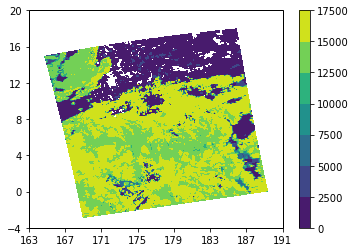

In [91]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

test = lon_m
test[test < 0] = test[test < 0] + 360

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
c = plt.contourf(test,lat_m,ct_m,transform=ccrs.Mercator())
cb = plt.colorbar(c)
ax.set_xticks(np.arange(163,192,4))
ax.set_yticks(np.arange(-4,21,4))

In [93]:
ax.get_extent()

(164.7555694580078, 189.32426452636716, -2.863499402999878, 17.948015213012695)

In [99]:
test2 = lon_c
test2[test2 < 0] = test2[test2 < 0] + 360

359.99937307997607

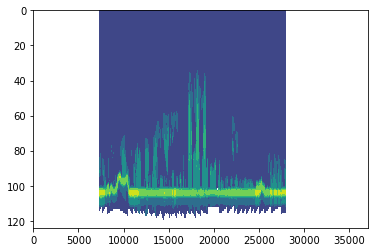

In [88]:
winlon = np.logical_or(test2 > 164, test2 < 190)
winlat = np.logical_or(lat_c > -3, lat_c < 18)



ax = plt.axes()
c = plt.contourf(ref_c.T)
ax.invert_yaxis()